# Income Predictor

In this project, I will use Machine Learning algorithms on `Census Income` dataset and classify individuals between having income salary `less than or equal to $50K` and `more than $50K`.

## Import Libraries and dataset

I will import `numpy`, `pandas` and `matplotlib` for working with the dataset. Next, I will use `sklearn` for using Machine Learning models. Finally, I'll import the dataset.

In [1]:
# Working with data
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore');

Next, I will import the dataset.

In [2]:
columns = ['Age', 'Work Class', 'Final Weight', 'Education', 'Education Number', 'Marital Status', 'Occupation',
          'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per Week', 'Country', 'Income']
dataset = pd.read_csv('income-dataset.csv', names = columns)

Before any analysis, let's convert the target column into numerical classes.

In [3]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
dataset['Income'] = labelEncoder.fit_transform(dataset['Income'])

## Exploratory Data Analysis and Data Processing

I'll next take a look at the data and draw visualizations to understand it better. I'll first take a look at the data collectively as a whole and then try to infer each column one by one.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age                 32561 non-null int64
Work Class          32561 non-null object
Final Weight        32561 non-null int64
Education           32561 non-null object
Education Number    32561 non-null int64
Marital Status      32561 non-null object
Occupation          32561 non-null object
Relationship        32561 non-null object
Race                32561 non-null object
Sex                 32561 non-null object
Capital Gain        32561 non-null int64
Capital Loss        32561 non-null int64
Hours per Week      32561 non-null int64
Country             32561 non-null object
Income              32561 non-null int64
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


The information above reveals that there are no missing values in the datatset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10acc9438>,
      dtype=object)

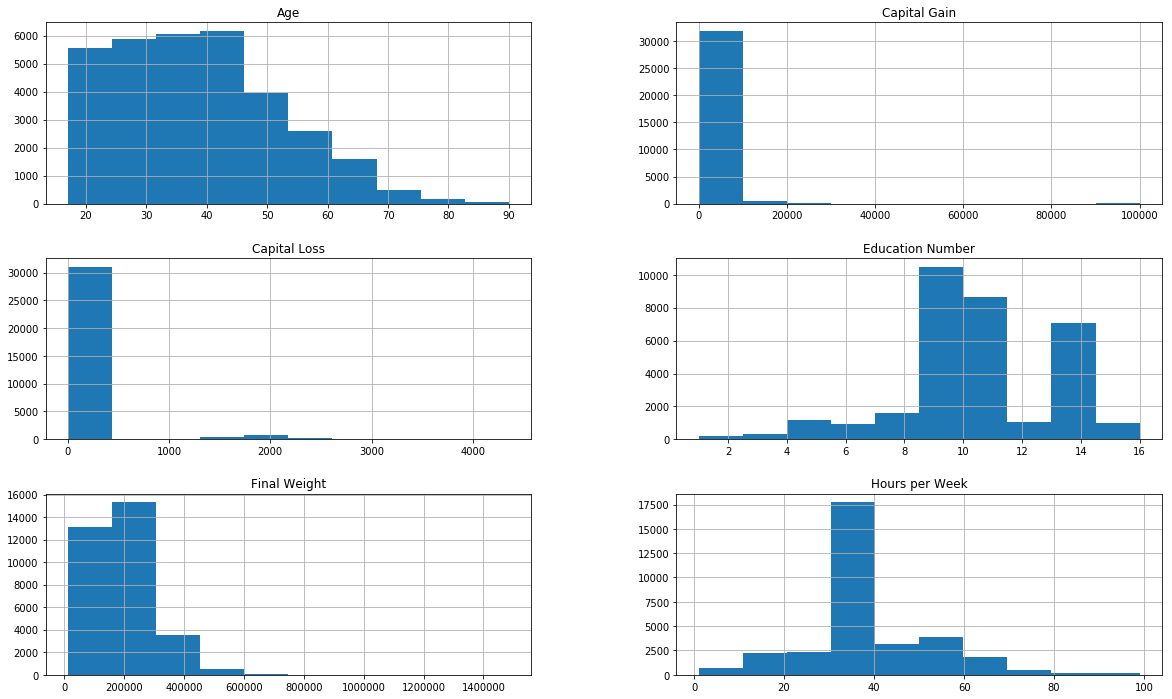

In [5]:
rcParams['figure.figsize'] = 20, 12
dataset[['Age', 'Final Weight', 'Education Number', 'Capital Gain', 'Capital Loss', 'Hours per Week']].hist()

From the histograms above, I can infer the following:
1. I can group the **Age** column into bins. 
2. For **Capital Gain** and **Capital Gain** the data is highly left skewed which needs to be tackled.
3. We need to analyse **Education Number** further as it might align with **Education** information.
4. **Final Weight** is also left skewed.
5. The **Hours per Week** can also be split into bins.

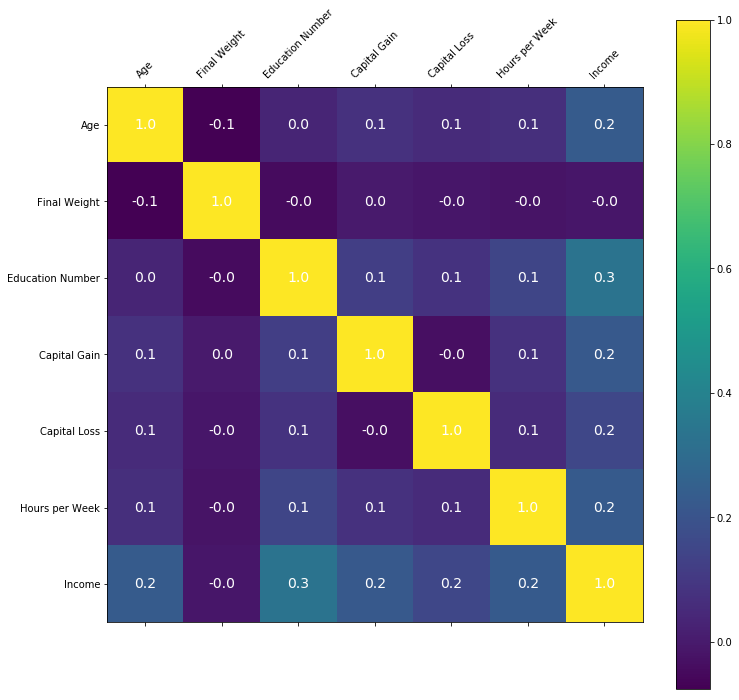

In [6]:
plt.matshow(dataset.corr())
plt.colorbar()
plt.xticks(np.arange(len(dataset.corr().columns)), dataset.corr().columns.values, rotation = 45) 
plt.yticks(np.arange(len(dataset.corr().columns)), dataset.corr().columns.values) 
for (i, j), corr in np.ndenumerate(dataset.corr()):
    plt.text(j, i, '{:0.1f}'.format(corr), ha='center', va='center', color='white', fontsize=14)

Taking a look at the correlation matrix above, it's clear that there is not a very high linear correlation between any of the continuous features and the target variable. Also, `Final Weight` has zero correlation with the output class and hence, I'll drop this column later.

I'll now analyse the categorical features using `CountPlot`.

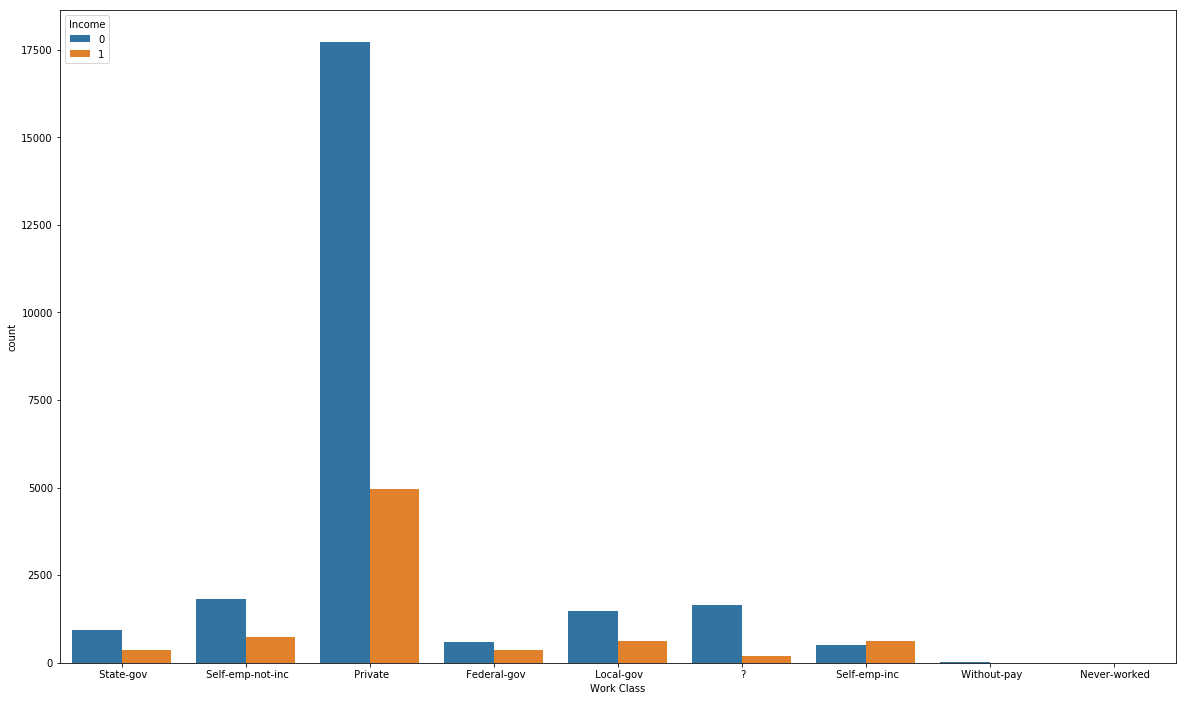

In [7]:
import seaborn as sns

categorical = ['Work Class', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
sns.countplot(x = 'Work Class', hue = 'Income', data = dataset)

### Age

Here, I'll bucket the age into separate bins.
1. 0-25: Young
2. 25-50: Adult
3. 50-100: Old

In [8]:
dataset['Age'] = pd.cut(dataset['Age'], bins = [0, 25, 50, 100], labels = ['Young', 'Adult', 'Old'])            

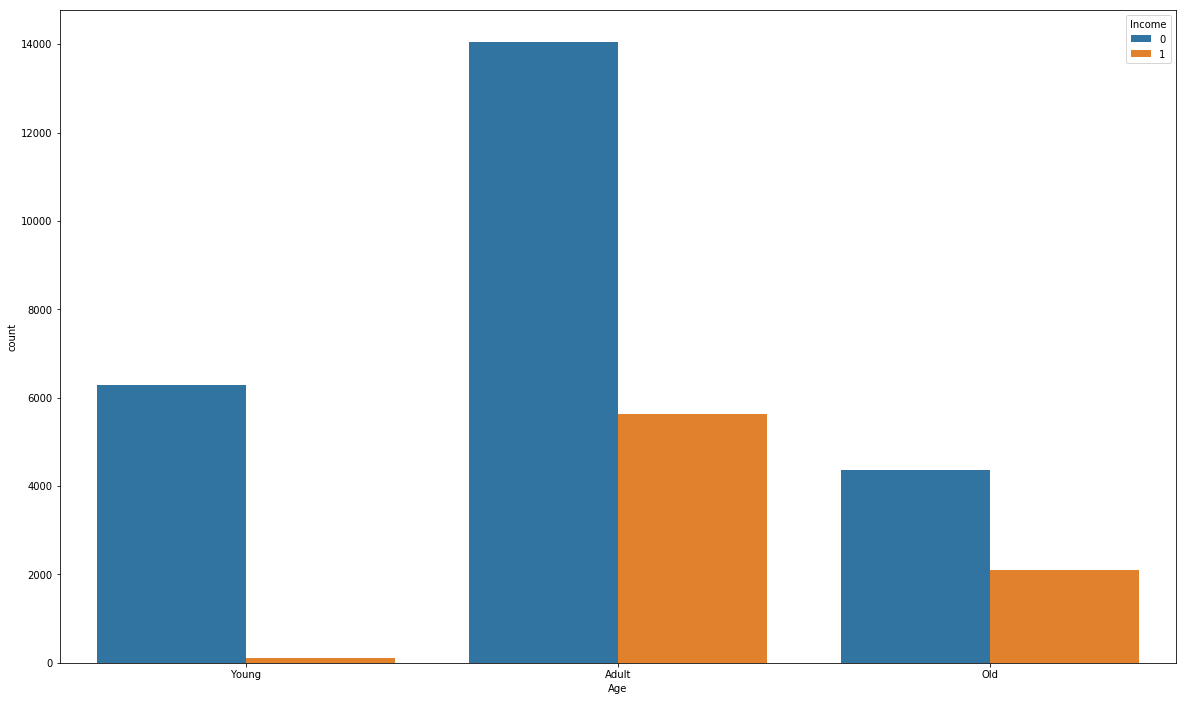

In [9]:
sns.countplot(x = 'Age', hue = 'Income', data = dataset)

I analyse that there are more adults with Salary more than $50K than old and young members of the dataset.

### Capital Gain and Capital Loss

Rather than having both `Capital Gain` and `Capital Loss`, I will use their difference as that is more relevant and gives the change.

In [10]:
dataset['Capital Diff'] = dataset['Capital Gain'] - dataset['Capital Loss']
dataset.drop(['Capital Gain'], axis = 1, inplace = True)
dataset.drop(['Capital Loss'], axis = 1, inplace = True)

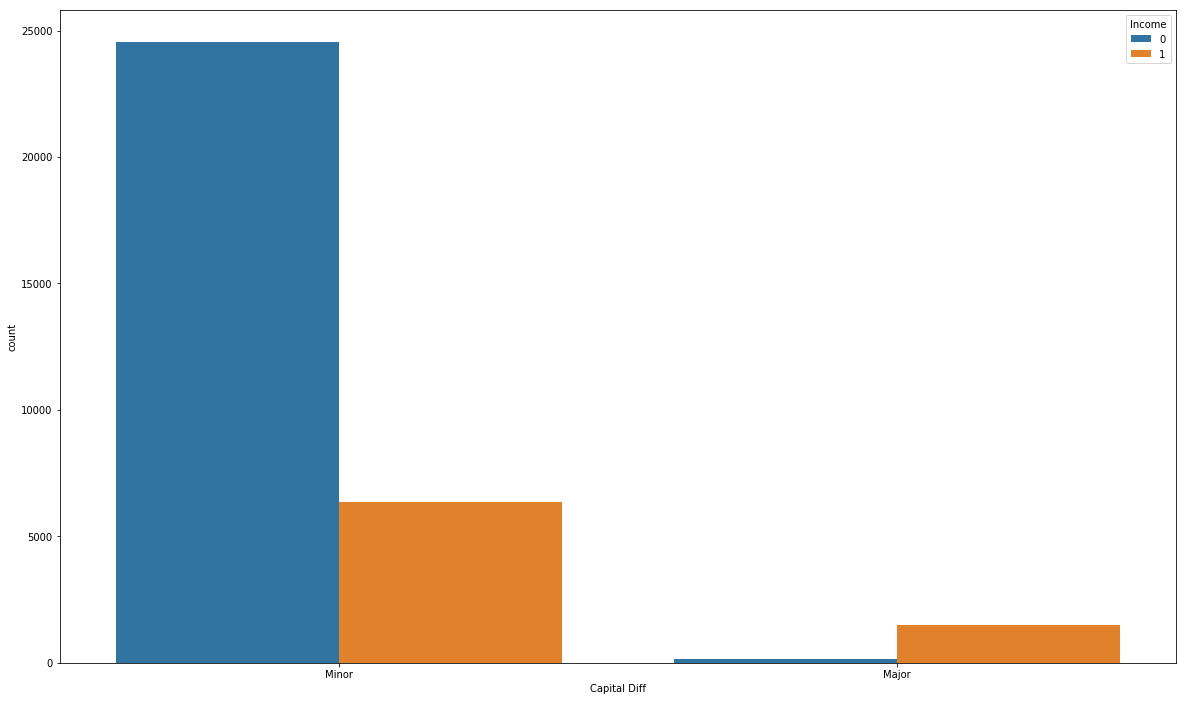

In [11]:
dataset['Capital Diff'] = pd.cut(dataset['Capital Diff'], bins = [-5000, 5000, 100000], labels = ['Minor', 'Major'])
sns.countplot(x = 'Capital Diff', hue = 'Income', data = dataset)

On taking a look at the result, I can see that the for `Minor` there are more people with Income less than `$50K` and for `Major` there are more people with Income greater than `$50K`. This is in complete agreement with the fact that people who have large `Capital Gain` compared to `Capital Loss` have `Income` more than `$50K`. 

### Final Weight

As seen above, there is no correlation between Income and Final Weight, so I will drop this column.

In [12]:
dataset.drop(['Final Weight'], axis = 1, inplace = True)

### Hours per Week

Taking a look at the histogram for `Hours per Week`, I can see that the dataset is aligned around the center. I can still create buckets from this data. As usually, the work hours are close to 30-40 hours, I create the buckets as `0-30`, `30-40`, and `40-100`.

In [13]:
dataset['Hours per Week'] = pd.cut(dataset['Hours per Week'], 
                                   bins = [0, 30, 40, 100], 
                                   labels = ['Lesser Hours', 'Normal Hours', 'Extra Hours'])

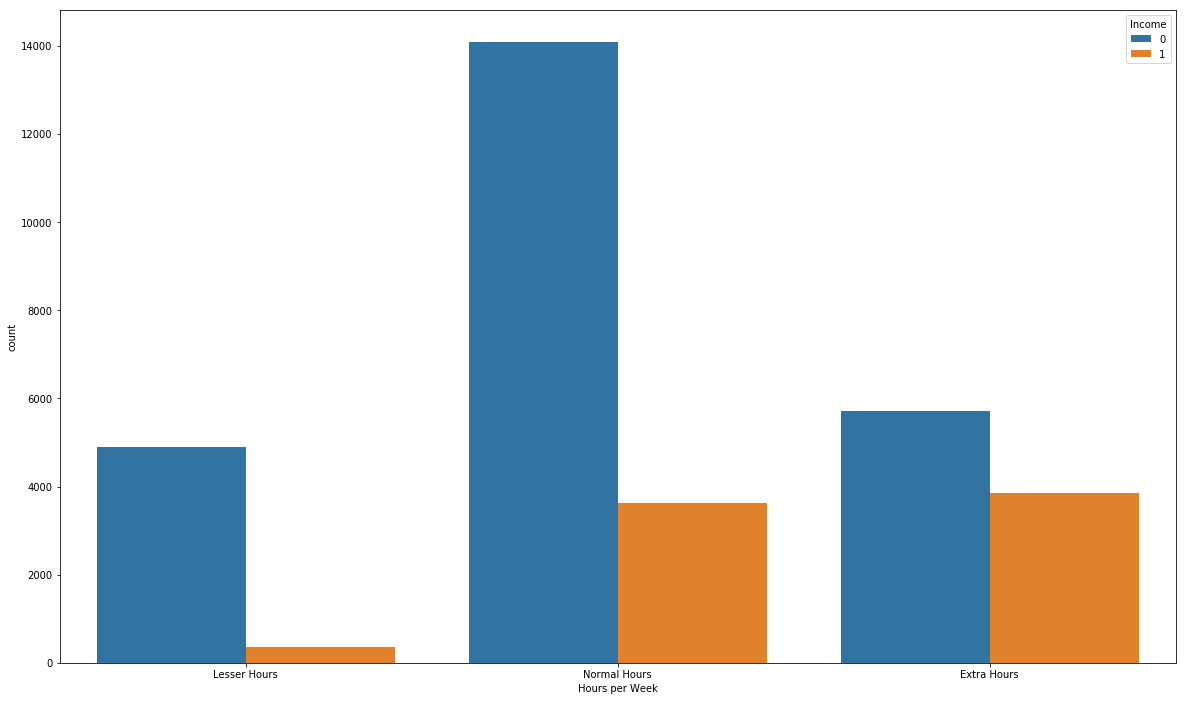

In [14]:
sns.countplot(x = 'Hours per Week', hue = 'Income', data = dataset)

Taking a look at the plot above, we can see a trend. As the number of hours increase, the number of people earning more than `$50K` increases in comparison to the people earning less.

### Work Class

Taking a look at the plot above, I can see that there are `Work Class` values defined as `?` which appears to be error data. As it is very less, I'll simply remove these records. Also, the two values `Without-pay` and `Never-worked` are neglibible and hence it is safe to drop them too.

In [15]:
dataset = dataset.drop(dataset[dataset['Work Class'] == ' ?'].index)
dataset = dataset.drop(dataset[dataset['Work Class'] == ' Without-pay'].index)
dataset = dataset.drop(dataset[dataset['Work Class'] == ' Never-worked'].index)

### Education and Education Number

It's a good time to check if there is any relation between Education and Education Number.

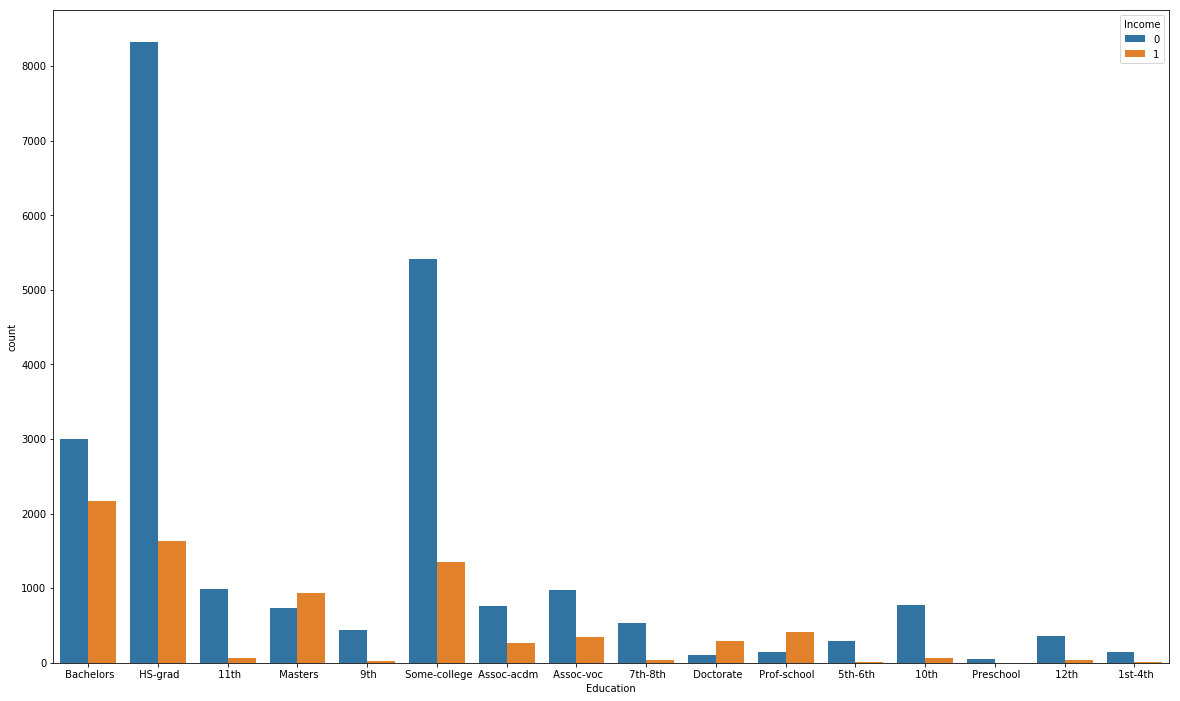

In [16]:
sns.countplot(x = 'Education', hue = 'Income', data = dataset)

In [17]:
education_classes = dataset['Education'].unique()
for edu_class in education_classes:
    print("For {}, the Education Number is {}"
          .format(edu_class, dataset[dataset['Education'] == edu_class]['Education Number'].unique()))

For  Bachelors, the Education Number is [13]
For  HS-grad, the Education Number is [9]
For  11th, the Education Number is [7]
For  Masters, the Education Number is [14]
For  9th, the Education Number is [5]
For  Some-college, the Education Number is [10]
For  Assoc-acdm, the Education Number is [12]
For  Assoc-voc, the Education Number is [11]
For  7th-8th, the Education Number is [4]
For  Doctorate, the Education Number is [16]
For  Prof-school, the Education Number is [15]
For  5th-6th, the Education Number is [3]
For  10th, the Education Number is [6]
For  Preschool, the Education Number is [1]
For  12th, the Education Number is [8]
For  1st-4th, the Education Number is [2]


From the analysis above, I discovered that **Education Number** and **Education** are just the same. So, I can drop any one column. Also, I'll combine all information from **Preschool** to **12th** as they can be considered of one class who have no college/university level education.

In [18]:
dataset.drop(['Education Number'], axis = 1, inplace = True)
dataset['Education'].replace([' 11th', ' 9th', ' 7th-8th', ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th'],
                             ' School', inplace = True)
dataset['Education'].value_counts()

 HS-grad         9959
 Some-college    6772
 Bachelors       5182
 School          3820
 Masters         1675
 Assoc-voc       1321
 Assoc-acdm      1019
 Prof-school      558
 Doctorate        398
Name: Education, dtype: int64

### Marital Status and Relationship

In [19]:
dataset['Marital Status'].value_counts()

 Married-civ-spouse       14331
 Never-married             9908
 Divorced                  4258
 Separated                  959
 Widowed                    839
 Married-spouse-absent      388
 Married-AF-spouse           21
Name: Marital Status, dtype: int64

In [20]:
dataset['Relationship'].value_counts()

 Husband           12700
 Not-in-family      7865
 Own-child          4520
 Unmarried          3269
 Wife               1432
 Other-relative      918
Name: Relationship, dtype: int64

Both of them have no missing values. There is some overlap between the two such as if the person is **Husband** or **Wife**, then their marital status would be **Married**. However, as there is no complete overlap, I'll keep both these columns.

### Occupation

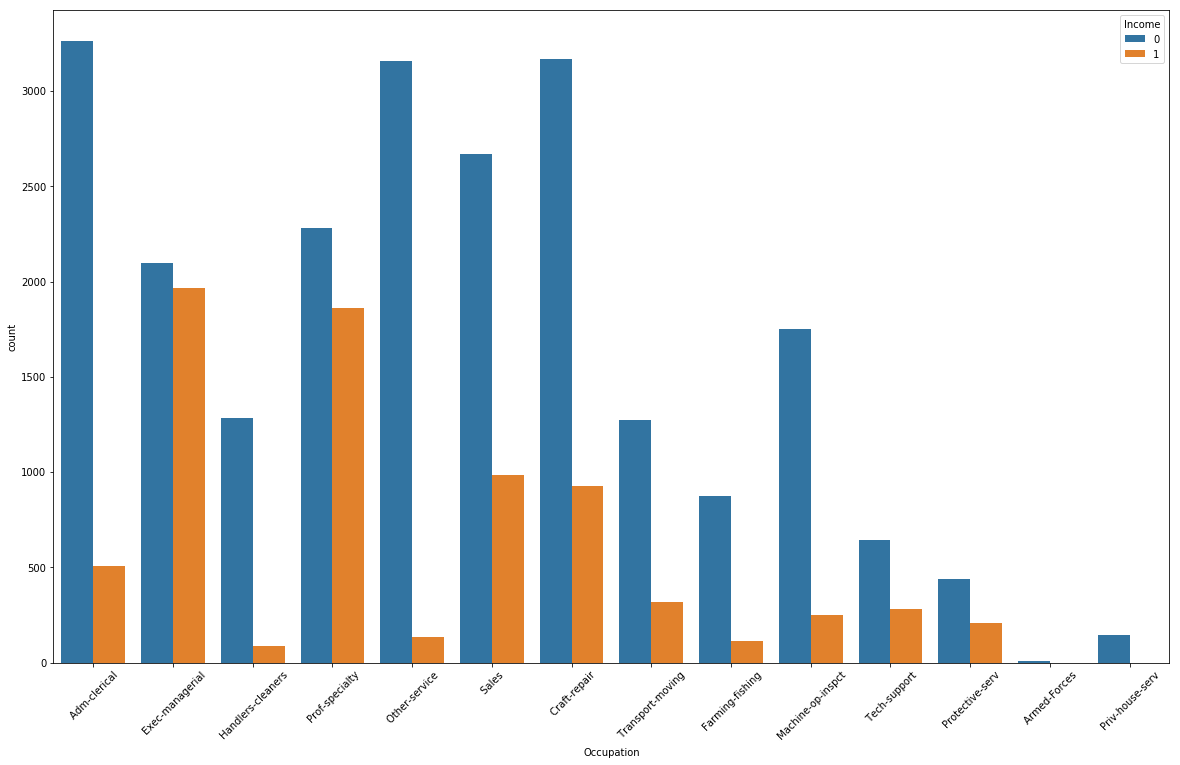

In [21]:
plt.xticks(rotation = 45)
sns.countplot(x = 'Occupation', hue = 'Income', data = dataset)

The data has no missing values. The categories have already been uniquely defined and we can keep it as is.

### Race

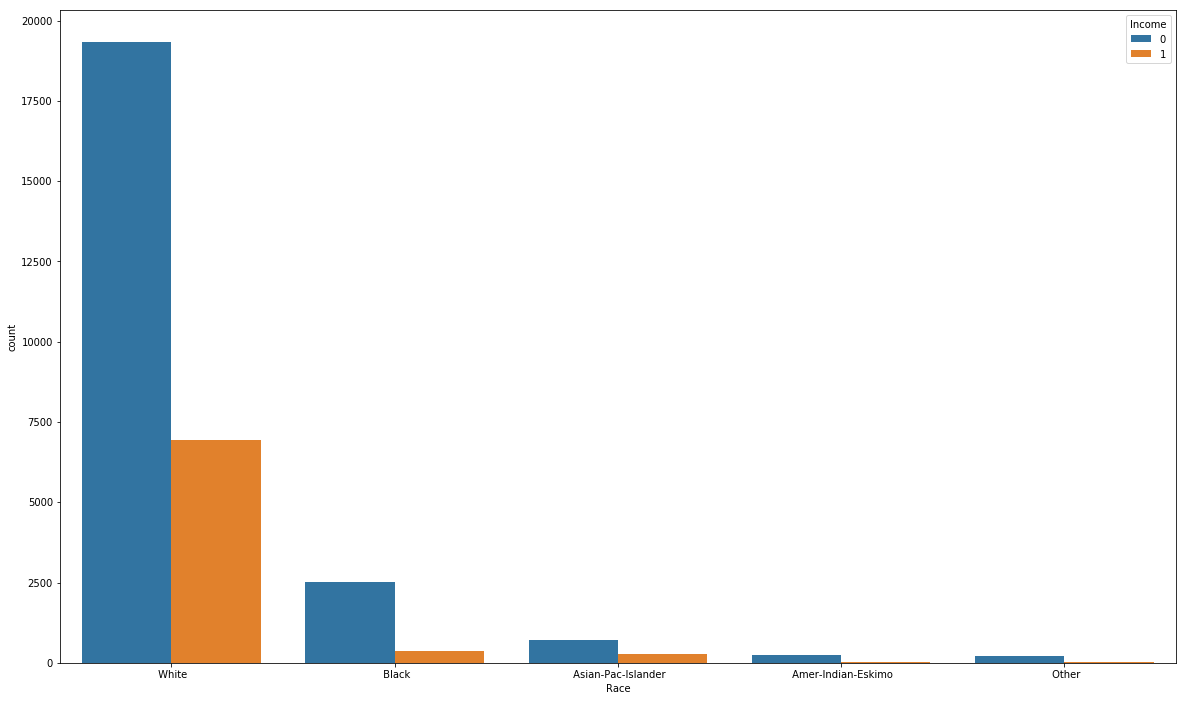

In [22]:
sns.countplot(x = 'Race', hue = 'Income', data = dataset)

The dataset includes majority of information about White race while all other races are lesser in number. I'll combine all other race data into one class as `Other`.

In [23]:
dataset['Race'].unique()
dataset['Race'].replace([' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other'],' Other', inplace = True)

### Sex

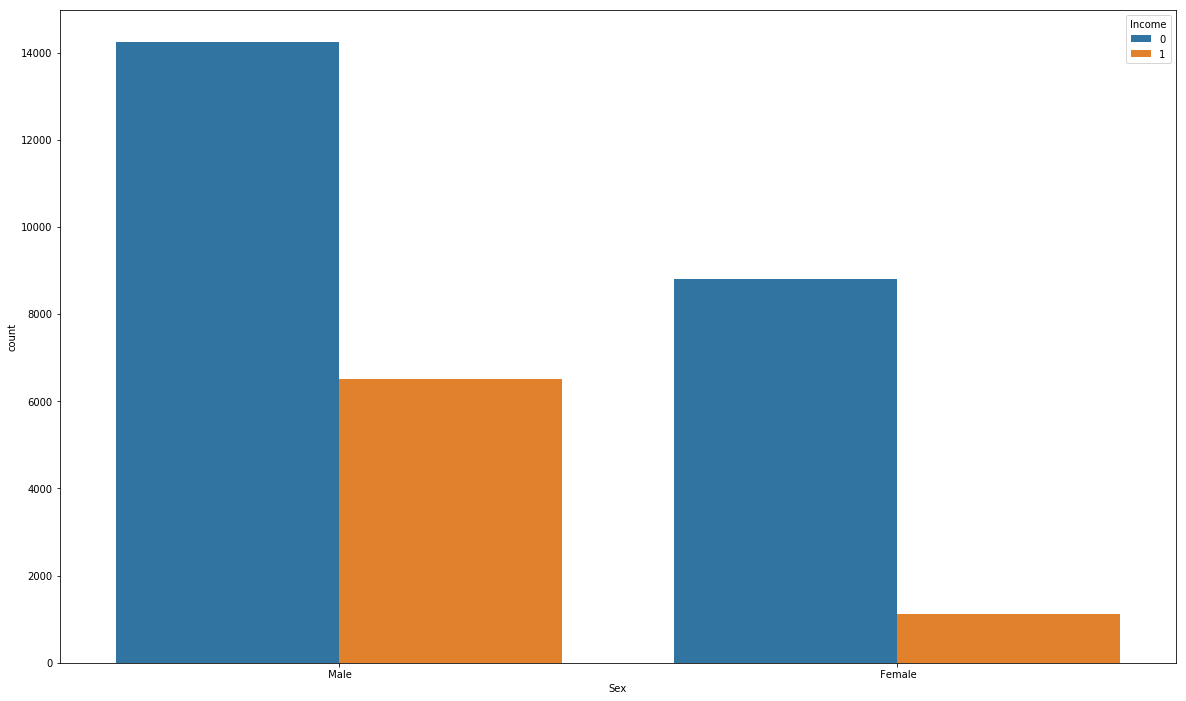

In [24]:
sns.countplot(x = 'Sex', hue = 'Income', data = dataset)

From the plot above, it is clear that 
1. There are more Male participants than Female participants
2. When we compare the two genders and the corresponding income distribution, more percentage of Men have an Income of more than \\$50K than Women.

### Country

In [25]:
country_count = dataset['Country'].value_counts()
country_count

 United-States                 27491
 Mexico                          610
 ?                               556
 Philippines                     187
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 India                           100
 El-Salvador                     100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 Italy                            68
 China                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Columbia                         56
 Poland                           56
 Haiti                            42
 Iran                             42
 Taiwan                           42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 

Text(0.5, 1.0, 'Total adults from each Country')

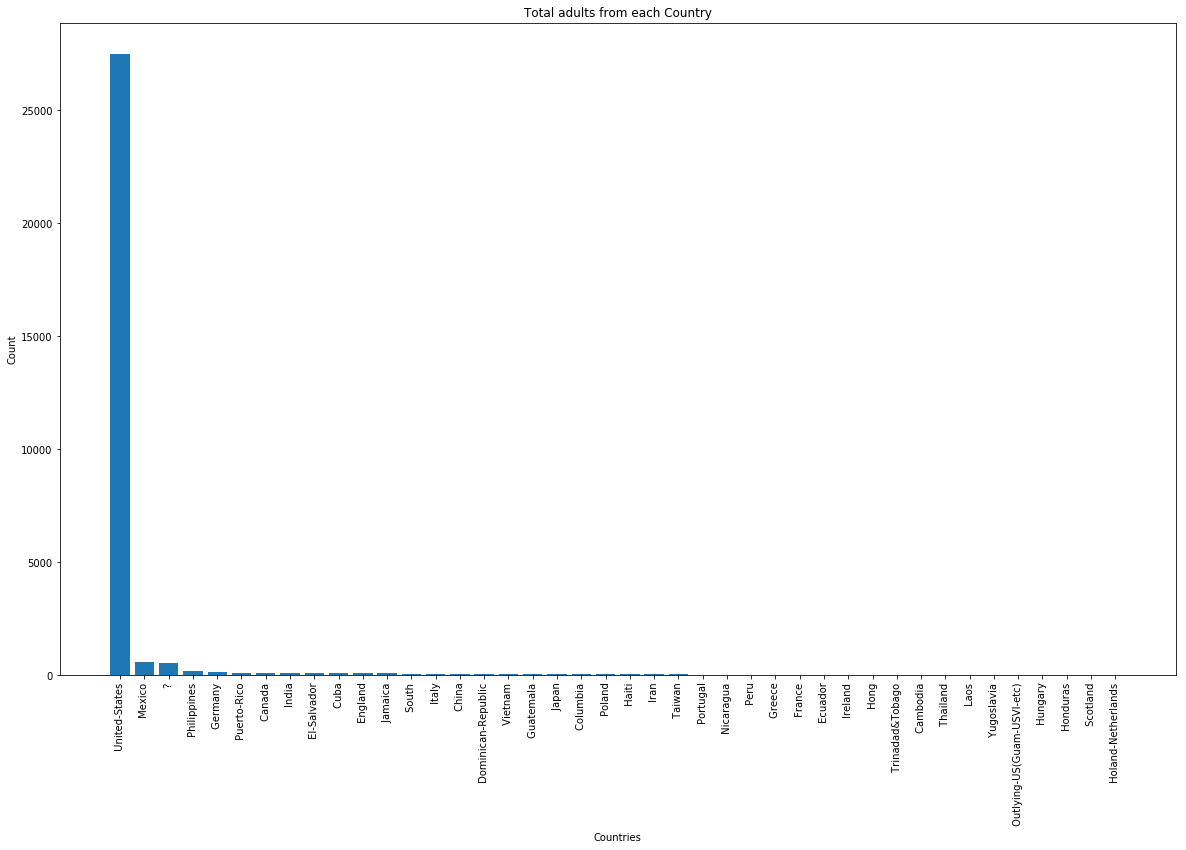

In [26]:
plt.bar(country_count.index, country_count.values)
plt.xticks(rotation = 90)
plt.xlabel('Countries')
plt.ylabel('Count')
plt.title('Total adults from each Country')

There are two things that I noticed:
1. There are some missing values in Country column denoted by ?. As they are very less, I'll drop these rows.
2. The majority of adults are from United States. Thus, we can distribute the column with values as either **United States** or **Other**.

In [27]:
dataset = dataset.drop(dataset[dataset['Country'] == ' ?'].index)

In [28]:
countries = np.array(dataset['Country'].unique())
countries = np.delete(countries, 0)

In [29]:
dataset['Country'].replace(countries, 'Other', inplace = True)

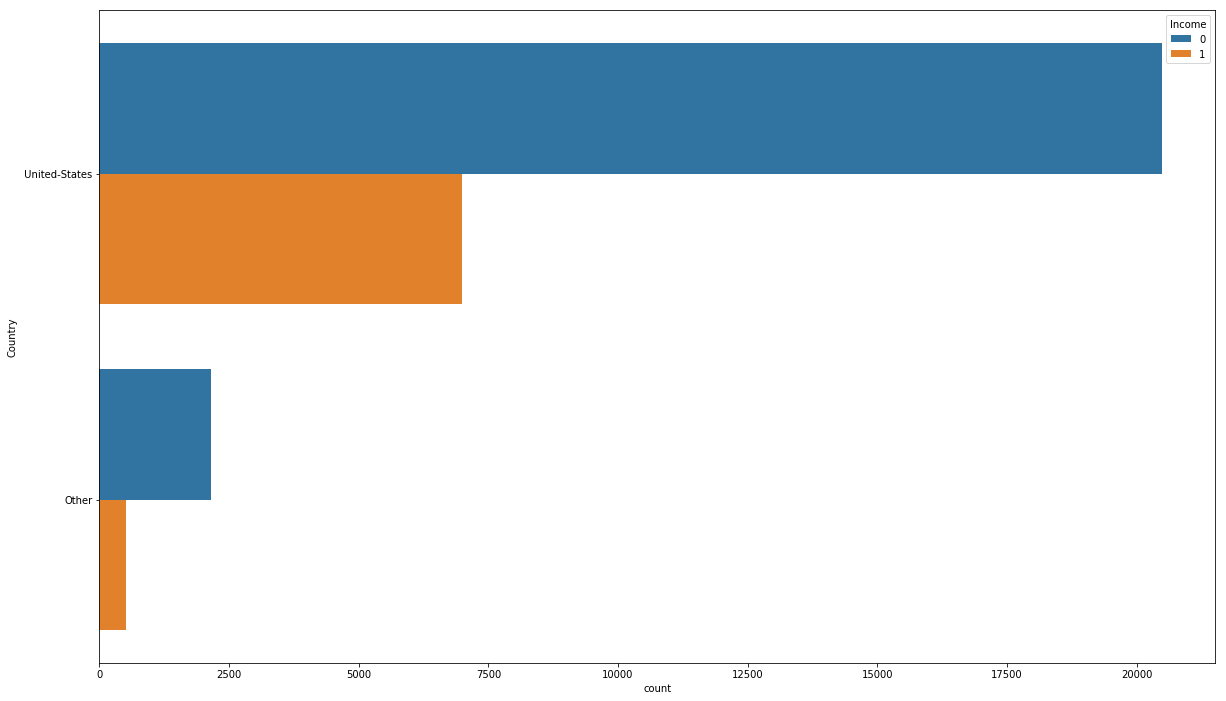

In [30]:
sns.countplot(y = 'Country', hue = 'Income', data = dataset)

The data now appears much better.

I've analysed all columns. I'll simply convert categorical columns to numerical.

## Data Manipulation

In this subsection, I'll take all the remaining columns and create important numerical values out of them.

I will use the `get_dummies` method of pandas to get separate columns for each feature based on the unqiue values in the dataset.

In [31]:
y = dataset['Income']
X = dataset.drop(['Income'], axis = 1)
X = pd.get_dummies(X)

Next, I will split the dataset into the training and testing data using `train_test_split`.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

We're now ready to start with Machine Learning.

## Applyting Machine Learning

In [33]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [34]:
classifiers = [GaussianNB(), 
               SVC(kernel = 'rbf', probability = True), 
               DecisionTreeClassifier(random_state = 0), 
               RandomForestClassifier(n_estimators = 100, random_state = 0), 
               GradientBoostingClassifier(random_state = 0)]
classifier_names = ["Gaussian Naive Bayes", 
                    "Support Vector Classifier", 
                    "Decision Tree Classifier", 
                    "Random Forest Classifier", 
                    "Gradient Bossting Classifier"]
accuracies = []

In [35]:
for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print("{}:".format(classifier_names[i]))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    accuracy = accuracy_score(y_test, y_pred)*100
    accuracies.append(accuracy)
    print("Accuracy: {:.2f}%\n".format(accuracy))

Gaussian Naive Bayes:
F1 score: 0.64
Accuracy: 75.22%

Support Vector Classifier:
F1 score: 0.62
Accuracy: 83.87%

Decision Tree Classifier:
F1 score: 0.62
Accuracy: 82.56%

Random Forest Classifier:
F1 score: 0.64
Accuracy: 83.42%

Gradient Bossting Classifier:
F1 score: 0.65
Accuracy: 84.27%



## Analysing Results

From the cells `F1 score` and `Accuracy` we can see that **GradientBoostingClassifier** performed the best with an **F1 score of 0.65** and **Accuracy of 84.27%**.

### Accuracy Plot

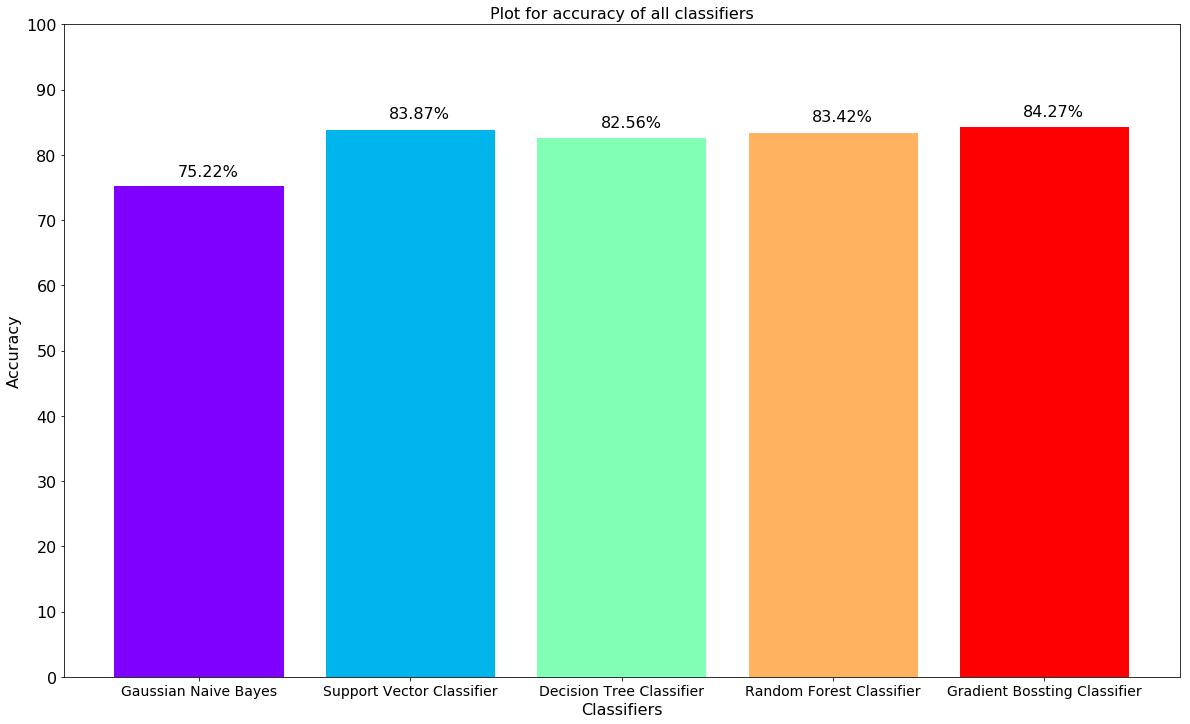

In [36]:
from matplotlib.cm import rainbow

plt.figure(figsize = (20, 12))
colors = rainbow(np.linspace(0, 1, len(classifiers)))
barplot = plt.bar(classifier_names, accuracies, color = colors)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize = 16)
plt.xticks(fontsize = 14)
plt.xlabel("Classifiers", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.title("Plot for accuracy of all classifiers", fontsize = 16)
for i, bar in enumerate(barplot):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, 
             bar.get_height()*1.02, 
             s = '{:.2f}%'.format(accuracies[i]), 
             fontsize = 16)

As it can be seen from the plot above, the **Gradient Boosting Classifier** had the best accuracy. Graphs make representing information really easy and intuitive.

### ROC Curve

Let's also analyse the ROC Curve for the predictions for income more than $50K.

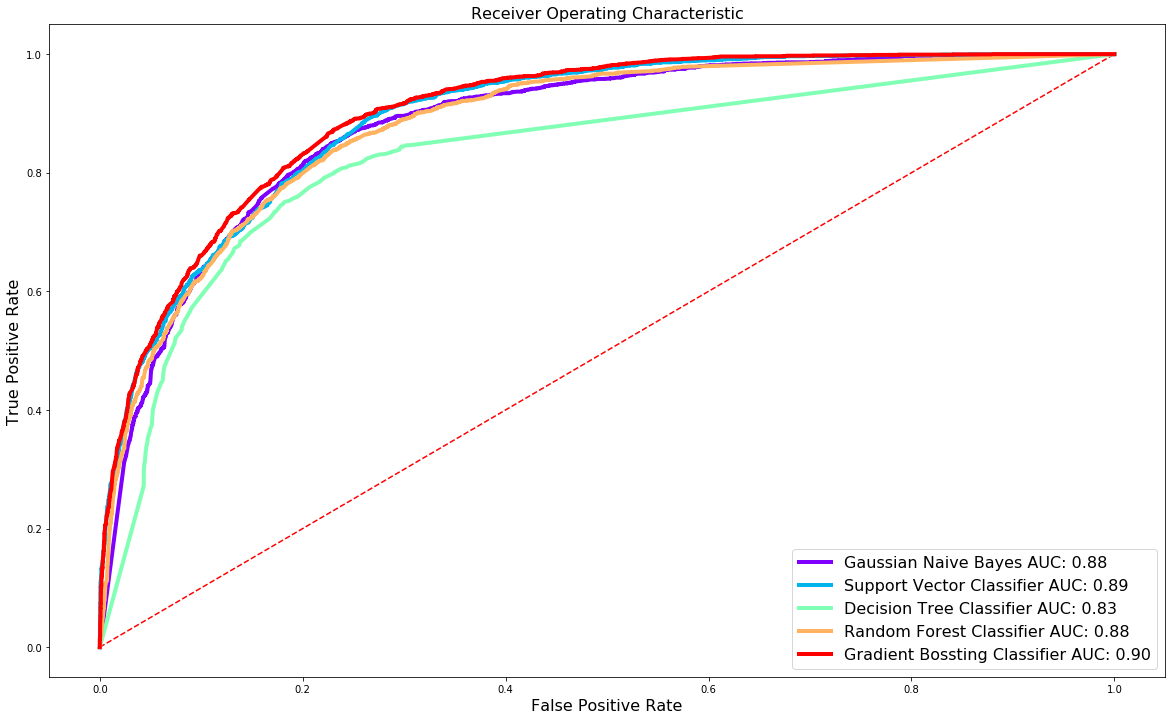

In [37]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

for i in range(len(classifiers)):
    classifier = classifiers[i]
    probs = classifier.predict_proba(X_test)
    # Reading probability of second class
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    label = classifier_names[i] + ' AUC:' + ' {0:.2f}'.format(roc_auc)
    plt.plot(fpr, tpr, c = colors[i], label = label, linewidth = 4)
    
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

Again, **Gradient Boosting Classifier** has the maximum **Area Under Curve** with a value of **0.90**.